In [22]:
#1) Import libraries
from qpsolvers import solve_qp
import time
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import Environments
import pandas as pd

In [23]:
#2) Create functions for quadratic computing
def H_funct(n):
    # H = np.zeros((3*n,3*n))
    H = np.diag([1e-2]*(3*n))
    for i in range(n):
        H[i*3+1,i*3+1] = 1
    return H

def Q_funct(n,vd):
    Q = np.zeros((3*n,))
    for i in range(n):
        Q[i*3+1]=-vd
    return Q

def A_funct(n,dt):
    A = np.zeros((2*n+2,3*n))
    for i in range(0,2):
        A[i,i]=1
        A[i+2*(n-1),i+2*(n-1)+(n-1)]=0
    for i in range(2,2*n):
        j=i+(i//2)
        #if(i<2*(n-1)):
        A[i,j]=-1
        A[i,j-3]=1
        A[i,j-2]=dt
        if(i%2==0): 
            A[i,j-1]=dt**2 /2
    for i in range(2*n,2*n+2):
        j=i+(i//2)-3
        A[i,j]=1
    return A

def A2_funct(n,dt):
    A = np.zeros((3*n,2*n+2))
    for i in range(0,2):
        A[i,i]=1
        A[i+2*(n-1)+(n-1),i+2*(n-1)]=0
    for i in range(2,2*n):
        j=i+(i//2)
        if(i<2*(n-1)):
            A[j,i]=-1
        A[j-3,i]=1
        A[j-2,i]=dt
        if(i%2==0): 
            A[j-1,i]=dt**2 /2
    for i in range(2*n,2*n+2):
        A[i,i]=1
    return A

def B_funct(n,xi,xf):
    B = np.zeros((2*n+2,))
    B[0:2]=xi
    B[2*n:]=xf
    return B

def B2_funct(n,xi,xf):
    B = np.zeros((2*n+2,))
    B[0]=xi[0]
    B[1]=xi[1]
    B[2*n]=xf[0]
    B[2*n+1]=xf[1]
    return B

def bounds(n,bds):
    bounds= np.zeros((3*n))
    for i in range(n):
        bounds[i*3:i*3+3]=bds
    return bounds


In [24]:
#3) Quadratic programming model
class Model_QP():
    """
        Class: select action
        :param dt: time step
        :param lb: lower bounds [position, speed, acceleration]
        :param ub: upper bounds [position, speed, acceleration]
    """
    def __init__(self, dt, lb, ub):
        self.dt = dt
        self.lb = lb
        self.ub = ub
        
    def new_action(self, n, x_init, x_final):
        """
        New action : 
        :param n: number of steps
        :param x_init: initial position & speed
        :param x_final: final position & speed
        :return: [position, speed, acceleration]
        """ 
        H=H_funct(n)
        q=Q_funct(n,x_final[1])
        A=A_funct(n,self.dt)
        B=B2_funct(n,x_init,x_final)
        lbs=bounds(n,self.lb)
        ubs=bounds(n,self.ub)
        return solve_qp(H, q, A=A, b=B, lb=lbs, ub=ubs)

In [65]:
#4) Rollout on the environment:
class Env_rollout:
    """ 
        Class : iterate on the environment
        :param env: our environment
        :param max_steps: max steps per episode
        :param dt: time step
        :param cross: size crosswalk
        :param cte_speed: acceleration for constant speed
    """
    def __init__(self, env, max_steps, dt, cross , cte_speed):
        self.env = env
        self.max_steps = max_steps
        self.dt = dt
        self.cross = cross
        self.cte_speed=cte_speed
        self.prev_state = env.reset()

    def iterations(self, model, nbr_episodes):
        """
        Iterate on the environment.
        :param model: current policy
        :param nbr_episodes: episode number
        :return: Tensors; state batch, action batch, reward batch
        """
        batch_obs=[]
        batch_acts=[]
        batch_rews=[]
        for ep in range(nbr_episodes):
            prev_state = env.reset()
            self.ds=prev_state[1]
            for step_ep in range(self.max_steps): 
                if(prev_state[3]<=0.1):
                    n=30
                else:
                    n=int((self.cross-prev_state[4])/(prev_state[3]*self.dt))
                initial_state = prev_state[1:3][1::-1]
                final_state = [0.0, self.ds]
                if(n<=0):
                    car_parameters=[0., 0., self.cte_speed]
                else:
                    car_parameters = model.new_action(n, initial_state, final_state)
                print(car_parameters is None)
                if(car_parameters is None or prev_state[4]>=self.cross):
                    print("Initial state: "+str(initial_state))
                    print("Final state: "+str(final_state))
                    print("N: "+str(n))
                    car_parameters=[0., 0., self.cte_speed] #à changer car le 0 du model dépend des limites de l'accélération                    
                print(car_parameters[2:3])
                state, reward, done, _ = self.env.step(car_parameters[2:3])
                batch_obs.append(prev_state)
                batch_acts.append(car_parameters[2])
                batch_rews.append(reward)
                prev_state = state
                if done:
                    break
            avg_reward = np.mean(batch_rews[-10:])
            print("Episode * {} * Avg Reward is ==> {} And Number of steps is ==> {}".format(ep, avg_reward,ep))
        return batch_obs, batch_acts, batch_rews



In [66]:
#4) QP Algorithm:
class Algo_QP():
    """ 
    QP algorithm : testing
    :param policy_class: policy
    :param env: environment
    :param hyperparameters: other hyperparameters
    """
    def __init__(self, policy_class, env, **hyperparameters):
        
        self._init_hyperparameters(hyperparameters)
        self.model = policy_class(self.dt, self.l_b, self.u_b)
        self.const_speed=-(self.u_b[2]+self.l_b[2])/(self.u_b[2]-self.l_b[2])
        self.rollout = Env_rollout(env, self.max_steps, self.dt, self.cross, self.const_speed)
    
    def evaluate(self, nbr_episodes):
        """
        Testing
        :param nbr_episodes: episode number 
        :return: state batch, action batch, and reward batch
        """
        state_batch, action_batch, rewards_batch = self.rollout.iterations(self.model, nbr_episodes)
        return state_batch, action_batch, rewards_batch
    
    def _init_hyperparameters(self, hyperparameters):
        """
        Initialize hyperparameters. 
        :param hyperparameters: hyperparameter list
        """
        for param, val in hyperparameters.items():
            exec('self.' + param + ' = ' + str(val))
        self.num_algo = 1
        self.max_steps = 90
        self.total_loop = 0
        self.dt = 0.3
        self.cross = 5.0
            

In [67]:
#5) Computing part:
# Import environment
problem = "Crossway_comparison-v0"
u_b = [2.0, 11.0, -22.5, 1.1, -1.0]
l_b = [-4.0, 9.0, -32.5, 0.9, -2.0]

env = gym.make(problem,dt=0.3,Vm=2.5,tau=1.0,lower_bounds=l_b, upper_bounds=u_b,simulation="sin")

# Initialize the algorithm
num_states = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
num_algo=1
u_b2=[40.0,15.0,2.0]
l_b2=[-40.0,-8.0,-4.0]
algo=Algo_QP(Model_QP, env, num_algo= num_algo, num_states=num_states, num_actions=num_actions,l_b=l_b2, u_b=u_b2)
#algo.loading(1,1000)

C:\Users\abrunoud\Anaconda3\envs\ppotest\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [68]:
#Stock an evaluation sample
states, actions, rewards = algo.evaluate(4)
states=np.array(states)
ep_action=states[:,0]
ep_speed_car=states[:,1]
ep_pos_car=states[:,2]
ep_speed_ped=states[:,3]
ep_pos_ped=states[:,4]
ep_time=states[:,9]
ep_reward=rewards
t=0

True
Initial state: [-24.747326  10.377088]
Final state: [0.0, 10.377088]
N: 20
[0.3333333333333333]
True
Initial state: [-21.6342    10.377088]
Final state: [0.0, 10.377088]
N: 19
[0.3333333333333333]
True
Initial state: [-18.521072  10.377088]
Final state: [0.0, 10.377088]
N: 18
[0.3333333333333333]
True
Initial state: [-15.407946  10.377088]
Final state: [0.0, 10.377088]
N: 17
[0.3333333333333333]
True
Initial state: [-12.294819  10.377088]
Final state: [0.0, 10.377088]
N: 24
[0.3333333333333333]
True
Initial state: [-9.181692 10.377088]
Final state: [0.0, 10.377088]
N: 30
[0.3333333333333333]
True
Initial state: [-6.068566 10.377088]
Final state: [0.0, 10.377088]
N: 30
[0.3333333333333333]
True
Initial state: [-2.9554396 10.377088 ]
Final state: [0.0, 10.377088]
N: 30
[0.3333333333333333]
True
Initial state: [ 0.15768671 10.377088  ]
Final state: [0.0, 10.377088]
N: 30
[0.3333333333333333]
True
Initial state: [ 3.270813 10.377088]
Final state: [0.0, 10.377088]
N: 30
[0.333333333333

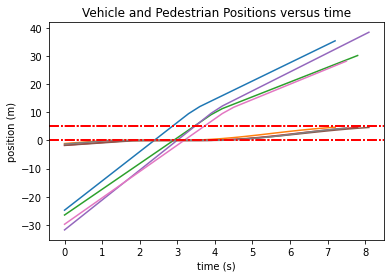

In [38]:
#Positions des agents
t=0
plt.title("Vehicle and Pedestrian Positions versus time")
plt.xlabel("time (s)")
plt.ylabel("position (m)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    plt.plot(ep_time[t_init:t],ep_pos_car[t_init:t])
    plt.plot(ep_time[t_init:t],ep_pos_ped[t_init:t])
    plt.axhline(y=5, color='r', linestyle='-.')
    plt.axhline(y=0, color='r', linestyle='-.')
    t+=1
_=plt.axhline(y=5, color='r', linestyle='-.')
_=plt.axhline(y=0, color='r', linestyle='-.')

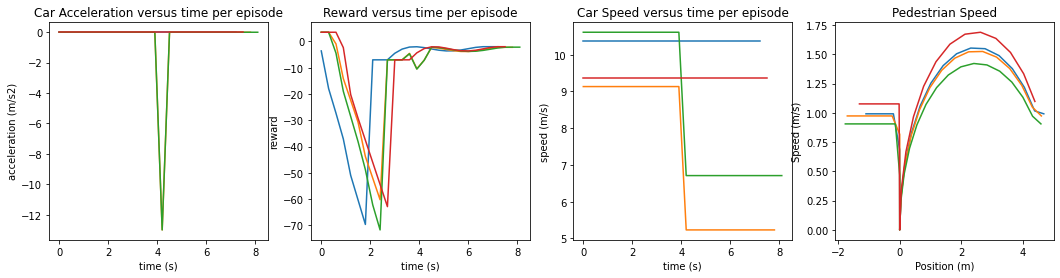

In [71]:
#Accélération, Reward, Vitesse de la voiture
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(18, 4))

t=0
ax1.set_title("Car Acceleration versus time per episode")
ax1.set_xlabel("time (s)")
ax1.set_ylabel("acceleration (m/s2)")

ax2.set_title("Reward versus time per episode")
ax2.set_xlabel("time (s)")
ax2.set_ylabel("reward")

ax3.set_title("Car Speed versus time per episode")
ax3.set_xlabel("time (s)")
ax3.set_ylabel("speed (m/s)")

ax4.set_title('Pedestrian Speed')
ax4.set_xlabel("Position (m)")
ax4.set_ylabel("Speed (m/s)")
while t+1<len(ep_time):
    t_init=t
    while t+1<len(ep_time) and ep_time[t]<ep_time[t+1]:
        t+=1
    ax1.plot(ep_time[t_init:t],ep_action[t_init:t])
    ax2.plot(ep_time[t_init:t],ep_reward[t_init:t])
    ax3.plot(ep_time[t_init:t],ep_speed_car[t_init:t])
    ax4.plot(states[t_init:t,4],states[t_init:t,3])
    t+=1


In [69]:
time_size=6.0 #time before pedestrian finish the crossing
dt=0.3
#n=int(time_size/dt)
n=20
H=H_funct(n)
q=Q_funct(n,10.0)
A=A_funct(n,0.3)
B=B2_funct(n,[-24.747326, 10.377088],[0.0, 10.377088])
lb=bounds(n,[-40.0,-8.0,-4.0])
ub=bounds(n,[40.0,15.0,2.0])
x = solve_qp(H, q, A=A, b=B, lb=lb, ub=ub)
#x

In [70]:
x

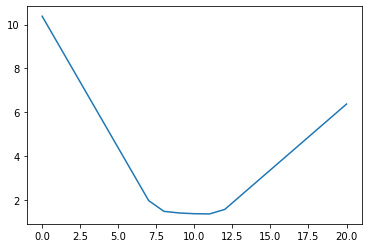

In [64]:
xv=x.reshape((-1,3))
plt.plot([i for i in range(n)],xv[:,1])